# minimal example of ontram implementation
- anlogous to https://github.com/liherz/ontram_pytorch.git

In [1]:
# Load dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split



from utils.configuration import *
from utils.loss_ordinal import *
from utils.tram_model_helpers import *
from utils.tram_models import *
from utils.tram_data import *


import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

Train with GPU support.


In [2]:
experiment_name = "ordinal_wine_example"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
# Load the dataset
wine = load_wine()
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [4]:
df=pd.DataFrame(wine['data'], columns=wine['feature_names'])
df['target']=wine['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]



# # 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)

def normalize_with_quantiles(df, min_vals, max_vals, exclude_columns=None):
    """
    Normalize df using (df - min) / (max - min), but skip any columns in exclude_columns.
    min_vals and max_vals should come from the training set.
    """
    exclude_columns = set() if exclude_columns is None else set(exclude_columns)
    normalized = df.copy()

    for col in df.columns:
        if col in exclude_columns:
            continue
        if col not in min_vals.index or col not in max_vals.index:
            continue
        min_val = min_vals[col]
        max_val = max_vals[col]
        range_ = max_val - min_val
        if range_ == 0 or pd.isna(range_):
            normalized[col] = df[col].apply(lambda x: 0.0 if not pd.isna(x) else x)
        else:
            normalized[col] = (df[col] - min_val) / range_
    return normalized



train_df = normalize_with_quantiles(train_df, min_vals, max_vals,exclude_columns=['target'])
val_df = normalize_with_quantiles(val_df, min_vals, max_vals,exclude_columns=['target'])
test_df = normalize_with_quantiles(test_df, min_vals, max_vals,exclude_columns=['target'])

In [6]:
train_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
158,1.043088,0.172521,0.940325,1.000000,0.325175,0.740162,0.253688,0.829060,0.946451,1.449339,0.000000,0.249189,0.320172,2
137,0.337298,1.257507,0.867993,1.000000,0.278555,0.213709,0.010120,1.073260,0.149440,0.364961,0.338524,0.124015,0.162452,2
98,0.274907,-0.000283,0.216998,0.407475,0.092075,1.115455,1.090738,0.120879,0.572852,0.297187,0.636425,0.624710,0.320172,1
159,0.707740,0.169688,0.867993,0.772106,0.115385,0.635913,0.181647,0.804640,0.742217,1.279905,0.000000,0.165739,0.276663,2
38,0.547865,0.121530,0.216998,0.134002,0.325175,0.531665,0.709949,0.218559,0.283935,0.188750,0.825999,0.587622,0.711753,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 158 to 102
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       142 non-null    float64
 1   malic_acid                    142 non-null    float64
 2   ash                           142 non-null    float64
 3   alcalinity_of_ash             142 non-null    float64
 4   magnesium                     142 non-null    float64
 5   total_phenols                 142 non-null    float64
 6   flavanoids                    142 non-null    float64
 7   nonflavanoid_phenols          142 non-null    float64
 8   proanthocyanins               142 non-null    float64
 9   color_intensity               142 non-null    float64
 10  hue                           142 non-null    float64
 11  od280/od315_of_diluted_wines  142 non-null    float64
 12  proline                       142 non-null    float64
 13  target  

In [8]:
train_df['target']

158    2
137    2
98     1
159    2
38     0
      ..
71     1
106    1
14     0
92     1
102    1
Name: target, Length: 142, dtype: int64

In [9]:
train_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
158,1.043088,0.172521,0.940325,1.000000,0.325175,0.740162,0.253688,0.829060,0.946451,1.449339,0.000000,0.249189,0.320172,2
137,0.337298,1.257507,0.867993,1.000000,0.278555,0.213709,0.010120,1.073260,0.149440,0.364961,0.338524,0.124015,0.162452,2
98,0.274907,-0.000283,0.216998,0.407475,0.092075,1.115455,1.090738,0.120879,0.572852,0.297187,0.636425,0.624710,0.320172,1
159,0.707740,0.169688,0.867993,0.772106,0.115385,0.635913,0.181647,0.804640,0.742217,1.279905,0.000000,0.165739,0.276663,2
38,0.547865,0.121530,0.216998,0.134002,0.325175,0.531665,0.709949,0.218559,0.283935,0.188750,0.825999,0.587622,0.711753,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.855917,0.124363,0.904159,1.000000,0.045455,0.818348,0.785420,0.047619,0.533001,0.145374,1.069736,0.805517,0.048241,1
106,0.228115,0.186686,0.241109,0.453054,-0.094406,0.140735,0.500686,0.438339,0.413450,0.148085,0.582261,0.810153,0.157013,1
14,1.058686,0.226346,0.554551,-0.185050,0.418415,1.000782,1.053002,0.242979,1.075965,0.703829,0.853081,0.731340,1.284984,0
92,0.399688,0.130028,0.409885,0.608022,-0.094406,0.000000,0.305146,0.951160,0.408468,0.100644,0.528097,0.295549,0.140697,1


data types

In [10]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']*13+['ordinal_Xc_Yo'])}
data_type

{'alcohol': 'continous',
 'malic_acid': 'continous',
 'ash': 'continous',
 'alcalinity_of_ash': 'continous',
 'magnesium': 'continous',
 'total_phenols': 'continous',
 'flavanoids': 'continous',
 'nonflavanoid_phenols': 'continous',
 'proanthocyanins': 'continous',
 'color_intensity': 'continous',
 'hue': 'continous',
 'od280/od315_of_diluted_wines': 'continous',
 'proline': 'continous',
 'target': 'ordinal_Xc_Yo'}

configartion dicitonary

In [11]:
configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
configuration_dict

{'date_of_creation': '2025-08-05 11:46:10',
 'experiment_name': 'ordinal_wine_example',
 'PATHS': {'DATA_PATH': '/home/bule/TramDag/dev_experiment_logs/ordinal_wine_example',
  'LOG_DIR': '/home/bule/TramDag/dev_experiment_logs',
  'EXPERIMENT_DIR': '/home/bule/TramDag/dev_experiment_logs/ordinal_wine_example'},
 'data_type': None,
 'adj_matrix': None,
 'model_names': None,
 'seed': None,
 'nodes': None}

modeloling it as a graph with one sink node 

In [12]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']*13+['ordinal_Xc_Yo'])}


columns = [
    'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
    'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
    'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target'
]

adj_matrix = np.full((len(columns), len(columns)), "0", dtype=object)

# Set last column (edges *to* 'target') as "ls", excluding self-loop
for i in range(len(columns) - 1):
    adj_matrix[i, -1] = "ls"
    
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
nn_names_matrix

array([['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        'LinearShift'],
       ['0', '0', '0', '0', '0

In [13]:
levels_dict=create_levels_dict(df,data_type)
target_nodes=create_node_dict(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict)
target_nodes

{'alcohol': {'Modelnr': 0,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 11.665000000000001,
  'max': 14.2295,
  'transformation_term_nn_models_in_h()': {}},
 'malic_acid': {'Modelnr': 1,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 1.0710000000000002,
  'max': 4.600999999999998,
  'transformation_term_nn_models_in_h()': {}},
 'ash': {'Modelnr': 2,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 1.92,
  'max': 2.7495,
  'transformation_term_nn_models_in_h()': {}},
 'alcalinity_of_ash': {'Modelnr': 3,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 14.030000000000001,
  'max': 25.0,
  'transformation_term_nn_mode

In [14]:
node='target'
tram_model=get_fully_specified_tram_model(node, target_nodes, verbose=True)
tram_model

TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=2, bias=False)
  )
  (nn_shift): ModuleList(
    (0-12): 13 x LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)

In [15]:
# from utils.tram_data import get_dataloader

learning_rate=0.001
use_scheduler=False


NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
os.makedirs(NODE_DIR, exist_ok=True)

MODEL_PATH,LAST_MODEL_PATH,TRAIN_HIST_PATH,VAL_HIST_PATH=model_train_val_paths(NODE_DIR)


optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)

if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
else:
    scheduler = None

train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=56,return_intercept_shift=True, verbose=False)


In [16]:
# TODO initialize with correct weights
epochs =1000
train_val_loop(
            node,
            target_nodes,
            NODE_DIR,
            tram_model,
            train_loader,
            val_loader,
            epochs,
            optimizer,
            use_scheduler,
            scheduler,
            save_linear_shifts=False,
            verbose=1,
            device=device,
            debug=True) # TODO startvalues for bernsteinpols



[DEBUG] Device: cuda
[DEBUG] Model paths: /home/bule/TramDag/dev_experiment_logs/ordinal_wine_example/target/best_model.pt /home/bule/TramDag/dev_experiment_logs/ordinal_wine_example/target/last_model.pt
[DEBUG] min_max shape: torch.Size([2])
Existing model found. Loading weights and history...


# Evaluate

In [17]:
## laoding the best model 
MODEL_PATH,LAST_MODEL_PATH,TRAIN_HIST_PATH,VAL_HIST_PATH=model_train_val_paths(NODE_DIR)

if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
    print("Existing model found. Loading weights and history...")
    tram_model.load_state_dict(torch.load(MODEL_PATH))

Existing model found. Loading weights and history...


In [ ]:
## evaluate on testdata
tram_model.eval()

_, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)

min_vals = torch.tensor(target_nodes[node]['min'], dtype=torch.float32).to(device)
max_vals = torch.tensor(target_nodes[node]['max'], dtype=torch.float32).to(device)
min_max = torch.stack([min_vals, max_vals], dim=0)


with torch.no_grad():
    for (int_input, shift_list), y in train_loader:
        int_input = int_input.to(device)
        shift_list = [s.to(device) for s in shift_list]
        y = y.to(device)

        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        # loss = contram_nll(y_pred, y, min_max=min_max)
        pred_labels = get_pdf_ordinal(get_cdf_ordinal(y_pred)).argmax(dim=1)
        true_labels = y.argmax(dim=1)
        accuracy = (pred_labels == true_labels).float().mean().item()

        print(f"Accuracy: {accuracy*100:.1f}%")  # → 100.0%




with torch.no_grad():
    for (int_input, shift_list), y in val_loader:
        int_input = int_input.to(device)
        shift_list = [s.to(device) for s in shift_list]
        y = y.to(device)

        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        # loss = contram_nll(y_pred, y, min_max=min_max)
        pred_labels = get_pdf_ordinal(get_cdf_ordinal(y_pred)).argmax(dim=1)
        true_labels = y.argmax(dim=1)
        accuracy = (pred_labels == true_labels).float().mean().item()

        
        print(f"Accuracy: {accuracy*100:.1f}%")  # → 100.0%

Accuracy: 89.3%
Accuracy: 89.3%
Accuracy: 96.7%
Accuracy: 100.0%


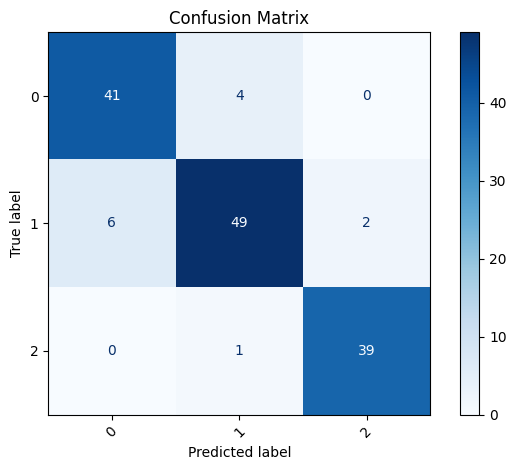

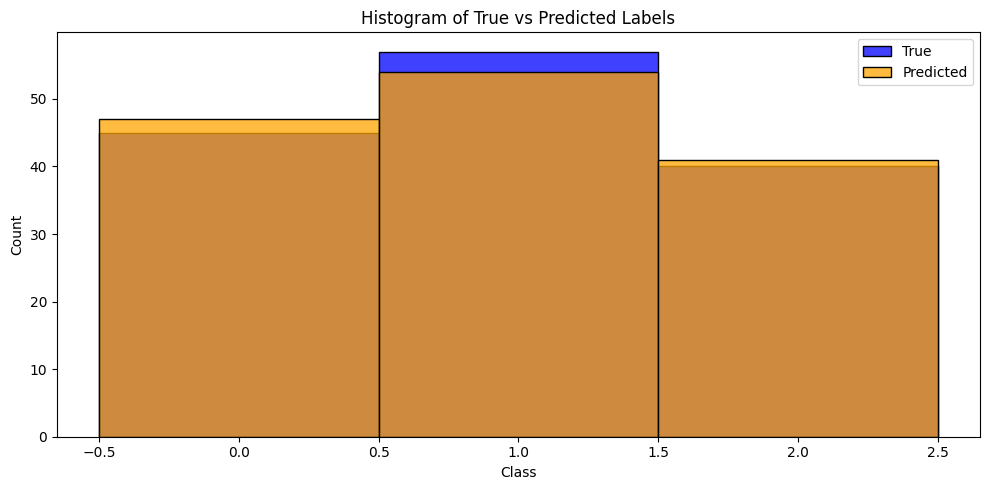

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

all_preds = []
all_trues = []

with torch.no_grad():
    for (int_input, shift_list), y in train_loader:
        int_input = int_input.to(device)
        shift_list = [s.to(device) for s in shift_list]
        y = y.to(device)

        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        pred_labels = get_pdf_ordinal(get_cdf_ordinal(y_pred)).argmax(dim=1)
        true_labels = y.argmax(dim=1)

        all_preds.append(pred_labels.cpu())
        all_trues.append(true_labels.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_trues = torch.cat(all_trues).numpy()

# --- Confusion Matrix ---
cm = confusion_matrix(all_trues, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# --- Histogram ---
plt.figure(figsize=(10, 5))
sns.histplot(all_trues, color="blue", label="True", kde=False, bins=np.arange(all_trues.max() + 2) - 0.5)
sns.histplot(all_preds, color="orange", label="Predicted", kde=False, bins=np.arange(all_preds.max() + 2) - 0.5)
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.title("Histogram of True vs Predicted Labels")
plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

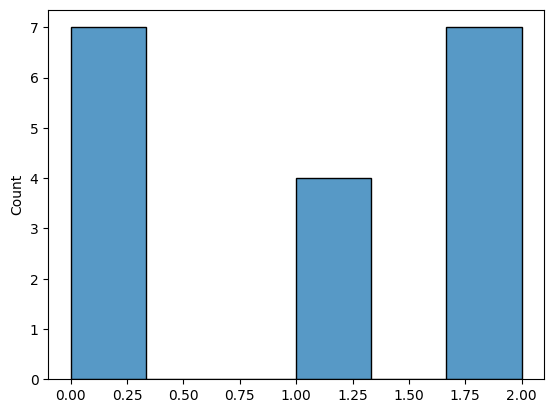

In [21]:
sns.histplot(true_labels.cpu())